In [1]:
from zipfile import ZipFile, ZIP_DEFLATED
import pathlib
import pandas as pd
import glob
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
import pytz
from parser_function import perform_calculations 

161748


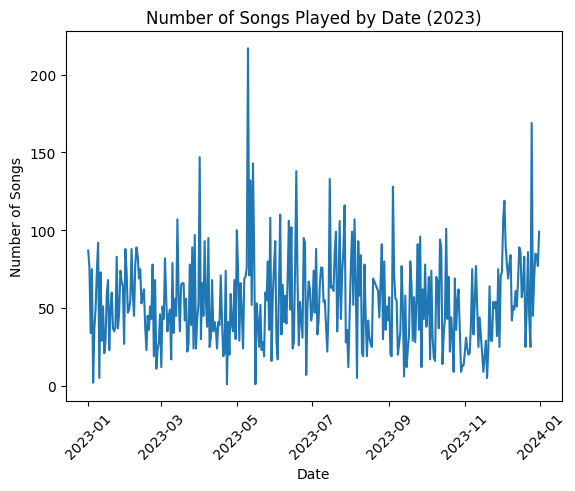

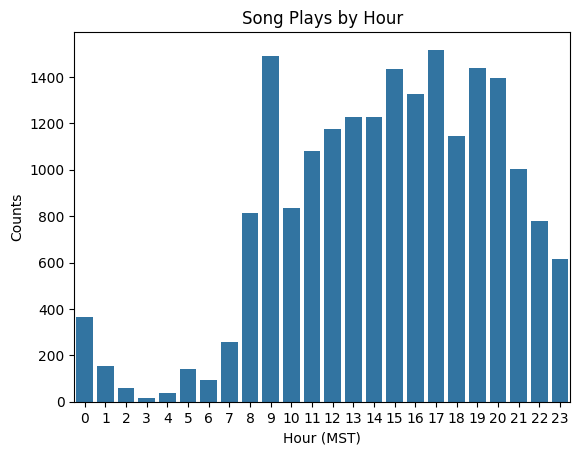

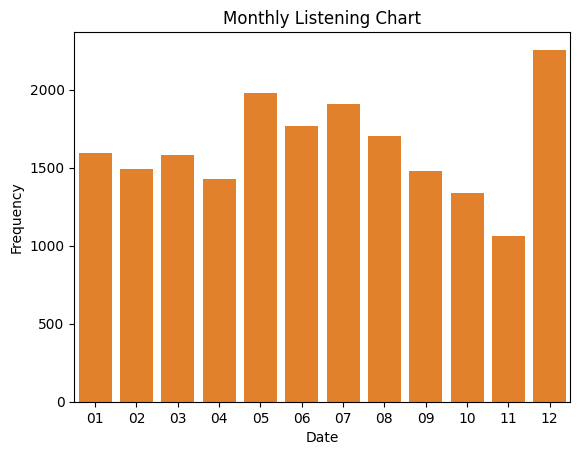

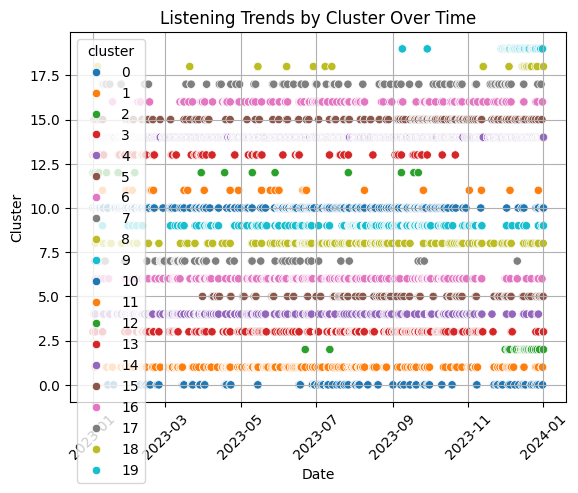

time_analysis.png
number_songs_played_by_date.png
top_10_songs.csv
monthly_analysis.png
top_new_artists.csv
daily_plot.png
Frequency graph for ['Lil Baby'].png
cluster_graph.png
diversity_score.txt
Frequency graph for ['Noah Kahan'].png
lib.txt
top_10_artist.csv


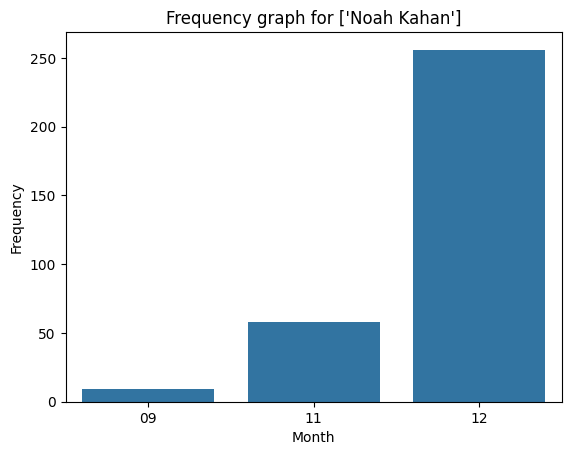

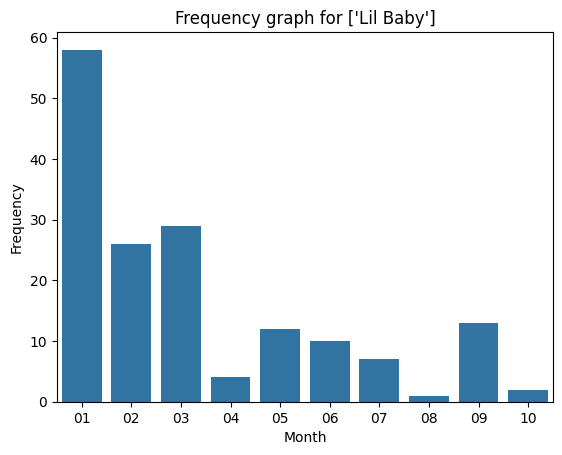

<Figure size 640x480 with 0 Axes>

In [2]:
perform_calculations('my_spotify_data.zip')

In [35]:
def extract_files(file_name):
    with ZipFile(file_name) as zip:
        zip.extractall('extracted') 

def combine_data():
    json_files = glob.glob('./extracted/Spotify Extended Streaming History/*.json')
    list_of_dfs = []
    for file in json_files:
        data = pd.read_json(file)
        list_of_dfs.append(data)
    combined_df = pd.concat(list_of_dfs, ignore_index = True)
    combined_df = combined_df.sort_values(by='ts')
    num = combined_df.shape[0]
    print(num)
    return combined_df
    

combined_df = combine_data()
#combined_df

161748


In [36]:
#Top artists 
def top_10_artist(combined_df):
    musical_artist = pd.DataFrame()
    top_artists = pd.DataFrame()
    #contain artist from songs listered(Music videos, podcasts don't count)
    musical_artist[['artist','song']] = combined_df.loc[combined_df['episode_name'].isnull(),
    ['master_metadata_album_artist_name','master_metadata_track_name']].copy()
    count = musical_artist.shape[0]
    top_artists = musical_artist.groupby(['artist']).agg(counts = ('song', 'count')).sort_values("counts", ascending=False)
    top_10_artists = top_artists[:10]
    return top_10_artists
#top_10_artists = top_10_artists(combined_df)
#top_10_artists
#musical_artist.head()
#artist_df.head()

In [37]:
#Top Songs of all time (listened to for more than 30 seconds)
def gen_top_songs(combined_df):
    top_songs = pd.DataFrame()
    #contain songs from audio songs(Music videos don't count)
    top_songs = combined_df.loc[combined_df['ms_played'] > 20000, ['master_metadata_track_name', 'master_metadata_album_artist_name']]
    top_songs.rename(columns = {'master_metadata_track_name':'song', 'master_metadata_album_artist_name':'artist'}, inplace =True)
    top_songs = top_songs.groupby('song').agg(listened_to = ('artist', 'count')).sort_values('listened_to', ascending = False)
    top_songs = top_songs[:10]
    return top_songs
#top_songs = gen_top_songs(combined_df)
#top_songs
#top_songs.to_json('file.json', orient = 'split', compression = 'infer', index = 'true')
#top_songs.to_csv('Top_songs_all_time.csv')

In [38]:
#discovery index(how often do you listen to new artists)
def gen_diversity_score(combined_df):
    year_of_data = pd.DataFrame()
    training_set = pd.DataFrame()
    unique_artist = pd.DataFrame()
    training_set =  combined_df.loc[(combined_df['ts'].str.split('T').str[0] < '2023'), 
                                  ['master_metadata_album_artist_name']]
    training_set.rename(columns = {'master_metadata_album_artist_name':'artist'}, inplace = True)
    training_set = training_set.drop_duplicates(subset = ['artist'])
    
    year_of_data = combined_df.loc[(combined_df['ts'].str.split('T').str[0] > '2023') & 
                                   (combined_df['ts'].str.split('T').str[0] < '2024'), 
                                  ['ts', 'master_metadata_album_artist_name']]
    year_of_data.rename(columns = {'master_metadata_album_artist_name':'artist'}, inplace = True)
    year_of_data = year_of_data.drop_duplicates(subset = ['artist'])
    
    unique_artist = year_of_data.loc[~year_of_data['artist'].isin(training_set['artist']), ['ts', 'artist']]
    diversity_score = unique_artist.shape[0] / year_of_data.shape[0]
    return diversity_score

In [39]:
#new artist + most listened to
def top_new_artists(combined_df):
    training_set1 =  combined_df.loc[(combined_df['ts'].str.split('T').str[0] < '2023'), 
                                    ['master_metadata_album_artist_name', 'master_metadata_track_name']]
    training_set1.rename(columns = {'master_metadata_album_artist_name':'artist', 'master_metadata_track_name': 'song'}, inplace = True)
    
    year_set = combined_df.loc[(combined_df['ts'].str.split('T').str[0] > '2023') & 
                               (combined_df['ts'].str.split('T').str[0] < '2024'), 
                              ['ts','master_metadata_album_artist_name', 'master_metadata_track_name', 'ms_played']]
    year_set.rename(columns = {'master_metadata_album_artist_name':'artist', 'master_metadata_track_name': 'song'}, inplace = True)
    
    unique_set = year_set.loc[~year_set['artist'].isin(training_set1['artist']), ['ts','artist', 'song', 'ms_played']]
    unique_set = unique_set.loc[unique_set['ms_played'] > 25000, ['ts','artist', 'song', 'ms_played']]
    unique_set1 = unique_set.groupby('artist').agg(ms_listened = ('ms_played', 'sum'),ts = ('ts', set),
                                                   song = ('song', set)).sort_values(by='ms_listened', ascending = False).reset_index()
    unique_set1.drop(['ms_listened', 'ts'], axis=1, inplace=True)
    return unique_set1[:10]


In [40]:
#Songs played in a year for more than 20 seconds
#uniques = combined_df.drop_duplicates(subset=['master_metadata_track_name'])
def make_unique_set(combined_df):
    uniques = combined_df.loc[combined_df['ms_played'] > 20000,['master_metadata_track_name','master_metadata_album_artist_name', 'spotify_track_uri', 'ts','ms_played']]
    uniques.rename(columns={'master_metadata_track_name':'song', 'master_metadata_album_artist_name':'artist', 'spotify_track_uri':'URI'}, inplace=True)
    uniques_2023 = uniques.loc[(uniques['ts'].str.split('T').str[0] > '2023') & (uniques['ts'].str.split('T').str[0] < '2024'), ['ts','song', 'artist', 'URI','ms_played']].reset_index()
    return uniques_2023

In [41]:
#make date plot
def date_plot(uniques_2023):
    uniques_2023['ts_date'] = pd.to_datetime(uniques_2023['ts']).dt.date
    # Count songs by date
    song_counts = uniques_2023.groupby('ts_date').size().reset_index(name='song_count')
    
    # Plot
    num_songs_played = sns.lineplot(data=song_counts, x='ts_date', y='song_count')
    plt.title("Number of Songs Played by Date (2023)")
    plt.xlabel("Date")
    plt.ylabel("Number of Songs")
    plt.xticks(rotation=45)
    plt.show()
    #saving pictures
    num_song_fig = num_songs_played.get_figure()
    num_song_fig.savefig('number_songs_played_by_date')


#uniques_2022 = uniques.loc[(uniques['ts'].str.split('T').str[0] > '2022') & (uniques['ts'].str.split('T').str[0] < '2023'), ['ts','song', 'artist', 'URI',]].reset_index()
# Sample data
#uniques_2022['ts_date'] = pd.to_datetime(uniques_2022['ts']).dt.date
# Count songs by date
#song_counts = uniques_2022.groupby('ts_date').size().reset_index(name='song_count')

# Plot
#sns.lineplot(data=song_counts, x='ts_date', y='song_count')
#plt.title("Number of Songs Played by Date (2022)")
#plt.xlabel("Date")
#plt.ylabel("Number of Songs")
#plt.xticks(rotation=45)
#plt.show()
#song_counts_avg = song_counts['song_count'].mean()
#print(song_counts_avg)


In [76]:
def monthly_listening(uniques_months_2023):
    uniques_2023['month'] = uniques_2023['ts'].astype(str).str.split('-').str[1]
    uniques_months_2023 = uniques_2023.copy()
    uniques_months_2023 = uniques_2023.groupby('month').agg(song_count = ('song','count'))
    monthly_listening_plt = sns.barplot(data = uniques_months_2023, x = 'month', y = 'song_count')
    plt.title('Monthly Listening Chart')
    plt.show()
    monthly_listening_fig = monthly_listening_plt.get_figure()
    monthly_listening_fig.savefig('monthly_analysis')
    return uniques_months_2023


In [74]:
#Time analysis
def time_analysis_plot(uniques_2023):
    uniques_2023['ts'] = pd.to_datetime(uniques_2023['ts'])
    
    uniques_2023['time_mst'] = uniques_2023['ts'].apply(
        lambda x: x.tz_convert('US/Mountain') if x.tzinfo else x.tz_localize('UTC').tz_convert('US/Mountain')
    )
    
    uniques_2023['hour'] = uniques_2023['time_mst'].dt.hour
    time_counts = uniques_2023.groupby('hour').agg(counts=('hour', 'count')).reset_index()
    
    time_analysis = sns.barplot(data=time_counts, x='hour', y='counts')
    plt.title('Song Plays by Hour')
    plt.xlabel('Hour (MST)')
    plt.ylabel('Counts')
    plt.show()
    
    time_song_fig = time_analysis.get_figure()
    time_song_fig.savefig('time_analysis')

In [26]:
def daily_plot(uniques_2023):
    daily_count = uniques_2023.groupby('ts_date').agg(day_count = ('song','count'))
    daily = sns.scatterplot(data=daily_count, x='ts_date', y='day_count')
    plt.title('Number of songs listed to per day (2023)')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    daily_fig = daily.get_figure()
    daily_fig.savefig('daily_plot')

In [125]:
#artist + date clustering
#clean 2023
#uniques has unique songs so this cant be used
def make_clusters(uniques_2023):
    top_2023_artists = uniques_2023.groupby('artist').agg(listened = ('ms_played','sum')).sort_values(by='listened', ascending = False)
    top_2023_artists = top_2023_artists.loc[top_2023_artists['listened'] > 9000000]
    
    ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas') 
    ohe_artists = ohe.fit_transform(uniques_2023[['artist']])
    top_2023_artists = pd.concat([uniques_2023, ohe_artists], axis=1)
    #top_2023_artists = top_2023_artists.drop(columns = ['artist'])
    top_2023_artists
    
    km = KMeans(n_clusters = 20).fit(ohe_artists)
    top_2023_artists['cluster'] = km.labels_
    uniques_2023['cluster'] = km.labels_
    cluster_graph = sns.scatterplot(data=top_2023_artists, x='ts', y='cluster', hue='cluster', palette='tab10')
    plt.title('Listening Trends by Cluster Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cluster')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    cluster_fig = cluster_graph.get_figure()
    cluster_fig.savefig('cluster_graph')
    return top_2023_artists

In [110]:
def make_ratios(uniques_2023):
    cluster_counts = uniques_2023.drop(columns = ['URI', 'time_mst'])
    cluster_counts['cluster_count'] = cluster_counts['cluster'].map(cluster_counts['cluster'].value_counts())
    filtered_counts = cluster_counts['cluster'].value_counts()
    filtered_counts = filtered_counts[filtered_counts > 50]
    cluster_counts
    
    cluster_by_month = cluster_counts.groupby(['month','cluster']).agg(monthly_appearence = ('cluster','count')).reset_index()
    cluster_by_month = cluster_by_month.sort_values(['cluster', 'month'])
    
    appearance_count = cluster_by_month.groupby('cluster')['monthly_appearence'].apply(lambda x: (x > 5).sum())
    cluster_by_month['appeared_in_#_month'] = cluster_by_month['cluster'].map(appearance_count)
    
    total_appearence = cluster_by_month.groupby('cluster')['monthly_appearence'].sum()
    cluster_by_month['total_appearence'] = cluster_by_month['cluster'].map(total_appearence)
    
    cluster_by_month = cluster_by_month.sort_values('appeared_in_#_month', ascending = True)
    cluster_by_month.loc[cluster_by_month['cluster'].unique()].sort_values(['cluster','total_appearence'], ascending = True)
    
    dominant_clusters = cluster_by_month.loc[cluster_by_month['appeared_in_#_month'] > 6].reset_index()
    
    non_dominant_clusters = cluster_by_month.loc[cluster_by_month['appeared_in_#_month'] < 6].reset_index()
    non_dominant_clusters = cluster_by_month.loc[cluster_by_month['monthly_appearence'] > 5].reset_index()
    #ratio = (#of months song appeared + #of total appearences of song) / (#total number of months + total # of all song appearences)
    #need to find highest number of apearences and lowest ppeared_in_#_month
    
    non_dominant_clusters['ratio'] = (non_dominant_clusters['appeared_in_#_month'] + non_dominant_clusters['total_appearence']) / (12 + filtered_counts.sum())
    non_dominant_clusters = non_dominant_clusters.loc[non_dominant_clusters['cluster'].unique()].sort_values(['ratio','cluster'], ascending = False)
    return non_dominant_clusters



In [259]:
def extract_cluster(top_2023_artists, cluster):
    cluster3 = top_2023_artists.loc[top_2023_artists['cluster'] == cluster,['song','artist','ts','month','ms_played']]
    total_played = cluster3.groupby('song').agg(total_played = ('ms_played','sum'))
    cluster3 = cluster3.merge(total_played, on='song')
    cluster3 = cluster3.sort_values(['total_played'],ascending = False).reset_index()    
    return cluster3

In [296]:
def cluster_graph(cluster):
    most_freq_month = cluster.groupby('month').agg(most_freq_month = ('song', 'count'))
    cluster = cluster.merge(most_freq_month, on='month')
    cluster = cluster.sort_values(['month'], ascending = True)
    freq_graph = sns.barplot(data = cluster, x = 'month', y = 'most_freq_month')
    plt.title(f"Frequency graph for {cluster['artist'].unique()}")
    plt.xlabel('Month')
    plt.ylabel('Frequency')
    freq_fig = freq_graph.get_figure()
    freq_fig.savefig(f"Frequency graph for {cluster['artist'].unique()}")
    plt.figure()
    return cluster


161748


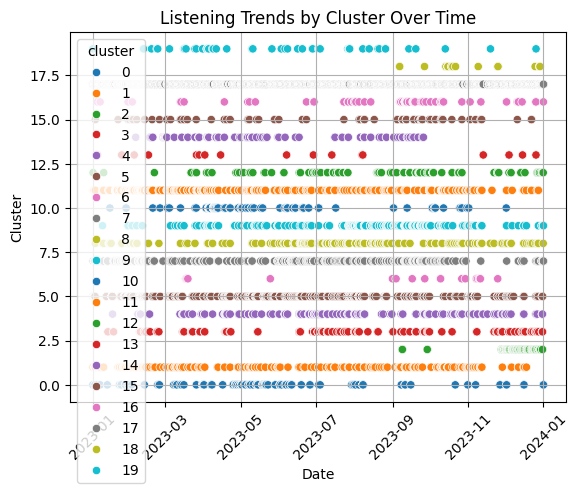

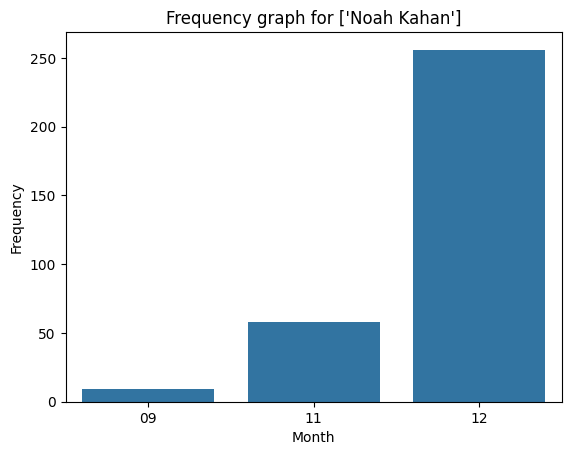

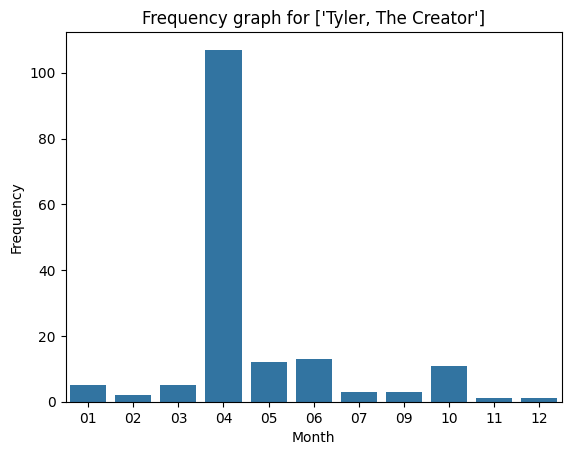

<Figure size 640x480 with 0 Axes>

In [298]:
#filename from lambda
filename = 'my_spotify_data.zip'
extract_files(filename)
combined_df = combine_data()
combined_df

#generates top 10 artists
top_10 = top_10_artist(combined_df)
#top_10.to_csv('top_10_artist.csv')
top_10

#generate top 10 songs
top_10_songs = gen_top_songs(combined_df)
#top_10_songs.to_csv('top_10_songs.csv')
top_10_songs

#generate diversity score
diversity_score = gen_diversity_score(combined_df)
#f = open("diversity_score.txt", "w")
#f.write(str(diversity_score))
#f.close()

#generate your top new found artists
top_new_artist = top_new_artists(combined_df)
#top_new_artist.to_csv('top_new_artists.csv')

#make all the graphs
#uniques_2023 = make_unique_set(combined_df)
#date_plot(uniques_2023)
#time_analysis_plot(uniques_2023)
#daily_plot(uniques_2023)

#monthly_listening(uniques_2023)

#make cluster
top_2023_artists = make_clusters(uniques_2023)
ratios = make_ratios(uniques_2023)
top_cluster = ratios['cluster'].unique()[:3]
cluster_df = pd.DataFrame()
for i in range(2):
    clust = extract_cluster(top_2023_artists, top_cluster[i])
    cluster_graph(clust)

    

In [316]:
def Zipit():
    directory_to_zip = './'
    zip_path = 'proccesed_data.zip'
    folder = pathlib.Path(directory_to_zip)
    suffixes = (".png", ".txt", ".csv")
    for file in folder.iterdir():
        if(file.name.endswith(suffixes)):
            print(file.name)
    with ZipFile(zip_path, 'w', ZIP_DEFLATED) as zip:
        for file in folder.iterdir():
            if(file.name.endswith(suffixes)):
                zip.write(file, arcname=file.name)
        
    

time_analysis.png
number_songs_played_by_date.png
top_10_songs.csv
monthly_analysis.png
view.csv
top_new_artists.csv
daily_plot.png
Frequency graph for ['Tyler, The Creator'].png
cluster_graph.png
diversity_score.txt
Frequency graph for ['Noah Kahan'].png
top_10_artist.csv


In [ ]:
#filename from lambda
def lambda_funct_proto(file_name)
    filename = 'my_spotify_data.zip'
    extract_files(filename)
    combined_df = combine_data()
    combined_df
    
    #generates top 10 artists
    top_10 = top_10_artist(combined_df)
    top_10.to_csv('top_10_artist.csv')
    top_10
    
    #generate top 10 songs
    top_10_songs = gen_top_songs(combined_df)
    top_10_songs.to_csv('top_10_songs.csv')
    top_10_songs
    
    #generate diversity score
    diversity_score = gen_diversity_score(combined_df)
    f = open("diversity_score.txt", "w")
    f.write(str(diversity_score))
    f.close()
    
    #generate your top new found artists
    top_new_artist = top_new_artists(combined_df)
    top_new_artist.to_csv('top_new_artists.csv')
    
    #make all the graphs
    uniques_2023 = make_unique_set(combined_df)
    date_plot(uniques_2023)
    time_analysis_plot(uniques_2023)
    daily_plot(uniques_2023)
    
    #monthly_listening(uniques_2023)
    
    #make cluster
    top_2023_artists = make_clusters(uniques_2023)
    ratios = make_ratios(uniques_2023)
    top_cluster = ratios['cluster'].unique()[:3]
    cluster_df = pd.DataFrame()
    for i in range(2):
        clust = extract_cluster(top_2023_artists, top_cluster[i])
        cluster_graph(clust)

In [5]:
directory_to_zip = './'
zip_path = 'proccesed_data.zip'
folder = pathlib.Path(directory_to_zip)
suffixes = (".png", ".txt", ".csv")
for file in folder.iterdir():
#    if(file.name.endswith(suffixes)):
    print(file.name)
with ZipFile(zip_path, 'w', ZIP_DEFLATED) as zip:
    for file in folder.iterdir():
        if(file.name == 'data' or file.name == 'package'):
            zip.write(file, arcname=file.name)

my_spotify_data.zip
spotify_parser.ipynb
number_songs_played_by_date.png
parser_function.py
.env
.zip
.ipynb_checkpoints
.git
data
.cache
extracted
lambda_function.py
lib.txt
package
